**Dissecting the Hype With Cheminformatics**

A recent paper in [Nature Biotechnology](https://www.nature.com/articles/s41587-019-0224-x) reported the use of AI in the discovery of inhibitors of [DDR1](https://en.wikipedia.org/wiki/DDR1), a kinase which has been implicated in fibrosis. Many who have worked in kinase drug discovery may have noticed that the most prominent compound (Compound 1 from this paper) bears a striking resemblance to a certain marketed drug. Let's assume the compound appears familiar, but we can't specifically place it. How can we use Cheminformatics to find drugs similar to the compound highlighted in this paper? Let's take look.

First, we will import the Python libraries that we'll need

In [1]:
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import rdFMCS
from tqdm import tqdm
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_useSVG = True
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

We will start with Compound 1 from the paper. 

In [5]:
compound_1_smiles = "Cc1ccc2c(Nc3cccc(c3)C(F)(F)F)noc2c1C#Cc1cnc2cccnn12"
compound_1_mol = Chem.MolFromSmiles(compound_1_smiles)

A quick check to ensure that we have the correct SMILES

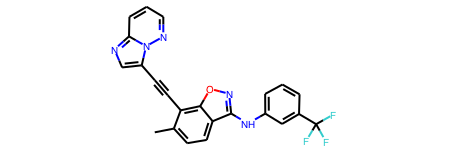

In [6]:
compound_1_mol

Now let's use the newly released [ChEMBL API](https://github.com/chembl/chembl_webresource_client) to grab the SMILES for all of the small molecule drugs. 

In [7]:
molecule = new_client.molecule
approved_drugs = molecule.filter(max_phase=4)
small_molecule_drugs = [x for x in approved_drugs if x['molecule_type'] == 'Small molecule']
struct_list = [(x['molecule_chembl_id'],x['molecule_structures'])for x in small_molecule_drugs if x]
smiles_list = [(a,b['canonical_smiles']) for (a,b) in struct_list if b]
smiles_df = pd.DataFrame(smiles_list)
smiles_df.columns = ['ChEMBL_ID','SMILES']

Now let's add a molecule column to the dataframe to make it easier to view the chemical structures

In [8]:
PandasTools.AddMoleculeColumnToFrame(smiles_df,'SMILES','Mol')

Now we'll add a fingerprint column to our Pandas table so that we can do a similarity search.

In [9]:
smiles_df['fp'] = [FingerprintMols.FingerprintMol(x) for x in smiles_df.Mol]

Next we can generate a fingerprint for Compound 1 and use that to do a similarity search. 

In [10]:
compound_1_fp = FingerprintMols.FingerprintMol(compound_1_mol)
smiles_df['fp_sim'] = [DataStructs.TanimotoSimilarity(compound_1_fp,x) for x in smiles_df.fp]
smiles_df.sort_values("fp_sim",inplace=True,ascending=False)

Let's look at the 5 most similar compounds

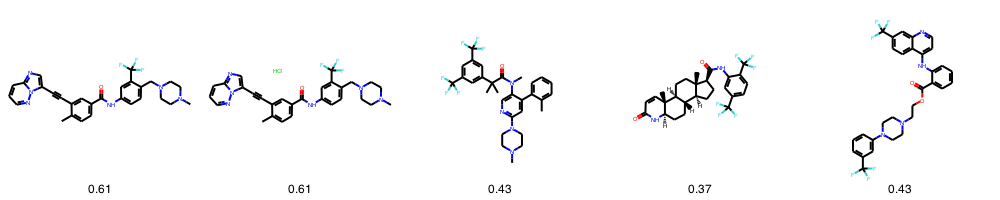

In [35]:
top5_sim_df = smiles_df.head()
MolsToGridImage(top5_sim_df.Mol,molsPerRow=5,legends=["%.2f" % x for x in top5_sim_df.fp_sim])

Hmmm, the first compound above looks a lot like Compound 1.  Just to be certain that we've found what we need, why don't we try an alternate method of calculating similarity.  In this case, we'll calculate the number of atoms in the maximum common subgraph (MCS) for Compound 1 and each of the small molecule drugs.  MCS calculations are time-consuming so this isn't the sort of thing we want to do with a large database.  However, is this case we only have a few thousand drugs, so the calculation isn't prohibitive.  On my MacBook Pro, this takes about a minute and a half. 

We'll start by defining a function that calculates the number of atoms in the MCS for two molecules.

In [17]:
def mcs_size(mol1,mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    return mcs.numAtoms

Next, we will run this over the small molecule drugs in our dataframe. 

In [20]:
mcs_list = []
for mol in tqdm(smiles_df.Mol):
    mcs_list.append(mcs_size(compound_1_mol,mol))

100%|██████████| 3147/3147 [01:36<00:00, 32.77it/s]


Now we can add the number of atoms in the MCS to our dataframe

In [21]:
smiles_df['mcs'] = mcs_list

Now we sort the dataframe by the number of atoms in the MCS and take a look at the 5 compounds with the largest MCS. 

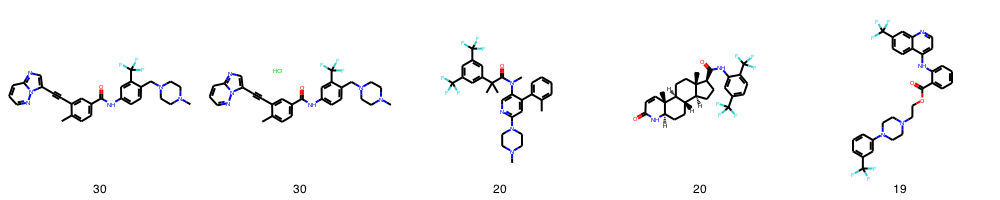

In [26]:
smiles_df.sort_values("mcs",inplace=True,ascending=False)
top5_mcs_df = smiles_df.head()
MolsToGridImage(top5_mcs_df.Mol,molsPerRow=5,legends=["%d" % x for x in top5_mcs_df.mcs])

While the two most similar molecules are the same as those we identified using the similarity search we can see that the MCS search uncovers a few different molecules. Let's learn a bit more about the drug that is most similar to Compound 1. We can start by getting its ChEMBL identifier.

In [92]:
top5_mcs.ChEMBL_ID.to_list()[0]

'CHEMBL1171837'

Now we can use the ChEMBL API to get the names associated with this molecule. 

In [28]:
molecule = new_client.molecule
m1 = molecule.get('CHEMBL1171837')
pd.DataFrame([(x['molecule_synonym'],x['syn_type']) for x in m1['molecule_synonyms']],columns=['molecule_synonym','syn_type'])

,molecule_synonym,syn_type
0,AP-24534,RESEARCH_CODE
1,Iclusig,TRADE_NAME
2,Ponatinib,ATC
3,Ponatinib,BNF
4,Ponatinib,INN
5,Ponatinib,USAN


This molecule is [Pontatinib](https://en.wikipedia.org/wiki/Ponatinib).  A quick Google search shows us that this is a marketed drug originally developed as an inhibitor of BCR-ABL. Ponatinib is also a promiscuous inhibitor of a number of [other kinases](https://www.dovepress.com/ponatinib-a-novel-multi-tyrosine-kinase-inhibitor-against-human-malign-peer-reviewed-fulltext-article-OTT) including [DDR1](https://www.sciencedirect.com/science/article/pii/S0022283614001983).  In fact, extensive SAR around the activity of Ponatinib analogs against DDR1 was reported in a [2013 paper in J.Med.Chem](https://pubs.acs.org/doi/10.1021/jm301824k).  

Let's generate a side-by-side visualization of Compound 1 and Ponatinib with the MCS highlighted. 

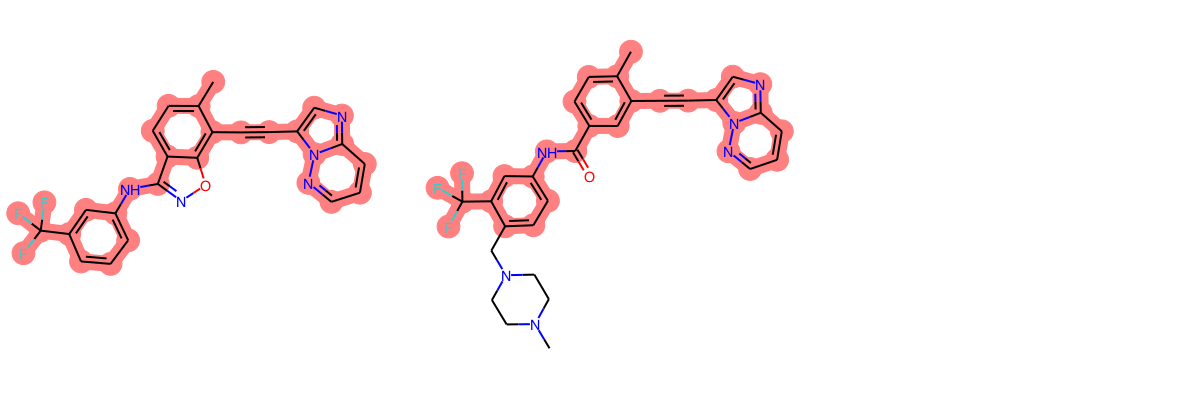

In [98]:
ponatinib_mol = top5_mcs.Mol.to_list()[0]
compound_1_mcs = rdFMCS.FindMCS([compound_1_mol,ponatinib_mol])
mcs_query = Chem.MolFromSmarts(compound_1_mcs.smartsString)
AllChem.Compute2DCoords(mcs_query)
for m in [compound_1_mol,ponatinib_mol]: AllChem.GenerateDepictionMatching2DStructure(m,mcs_query)
compound_1_match = compound_1_mol.GetSubstructMatch(mcs_query)
ponatinib_match = ponatinib_mol.GetSubstructMatch(mcs_query)
MolsToGridImage([compound_1_mol,ponatinib_mol],highlightAtomLists=[compound_1_match,ponatinib_match],subImgSize=(400, 400))

Given the similarity of Compound 1 to a marketed drug with 9nM biochemical activity against DDR1 and good pharmacokinetics (PK), the activity and PK profiles of Compound 1 are not particularly surprising. 